# Estimando o epicentro de um terremoto

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bordado as bd

## Gerar dados sintéticos

In [2]:
def distancia(x, y, x_rec, y_rec):
    return np.sqrt((x - x_rec)**2 + (y - y_rec)**2)

def dif_tempo(x, y, x_rec, y_rec, vp, vs):
    l = distancia(x, y, x_rec, y_rec)
    tempo = l * (1 / vs - 1 / vp)
    return tempo

[2.24700179 1.81454298 2.92874067]


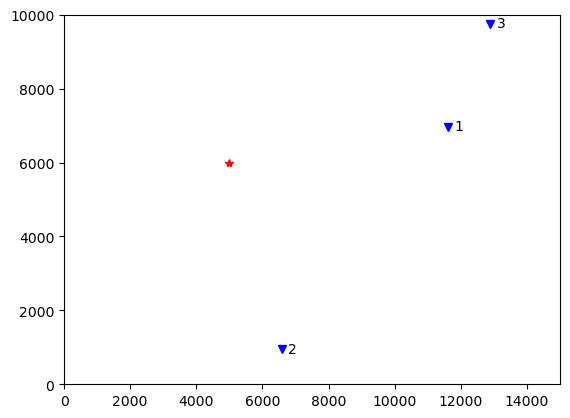

In [3]:
vp = 2000  # m/s
vs = 1200  # m/s
x_true, y_true = 5000, 6000  # m - epicentro verdadeiro
regiao = [0, 15e3, 0, 10e3]
x_rec, y_rec = bd.random_coordinates(regiao, size=3, random_seed=42)
# x_rec, y_rec = bd.random_coordinates([0, 4000, 0, 4000], size=3, rng=1)
dados = dif_tempo(x_true, y_true, x_rec, y_rec, vp, vs)
random = np.random.default_rng(1)
dados += random.normal(0, 0.02 * np.max(np.abs(dados)), dados.size)
print(dados)

plt.figure()
plt.plot(x_true, y_true, "*r")
plt.plot(x_rec, y_rec, "vb")
for xr, yr, i in zip(x_rec, y_rec, range(len(x_rec))):
    plt.text(xr + 200, yr - 100, i + 1)
plt.xlim(*regiao[:2])
plt.ylim(*regiao[2:])
plt.show()

## Mapa da função do ajuste

In [4]:
x, y = bd.grid_coordinates(regiao, spacing=100)

In [5]:
objetivo = np.empty_like(x)
for i in range(objetivo.shape[0]):
    for j in range(objetivo.shape[1]):
        predito = dif_tempo(x[i, j], y[i, j], x_rec, y_rec, vp, vs)
        residuo = dados - predito
        objetivo[i, j] = np.linalg.norm(residuo)**2

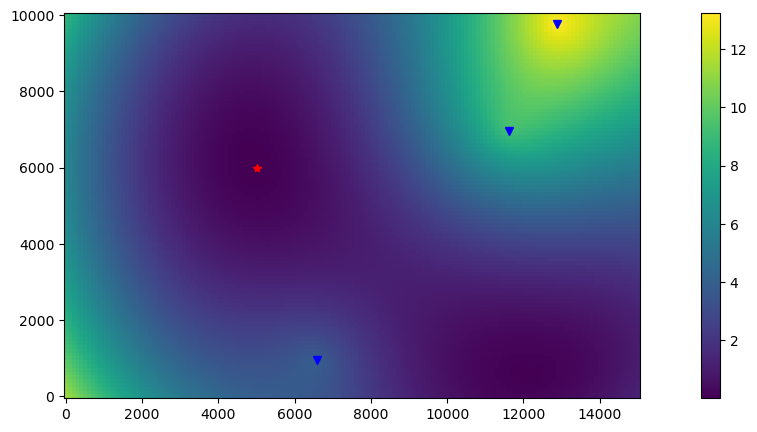

In [6]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(x, y, objetivo)
plt.colorbar()
plt.plot(x_true, y_true, "*r")
plt.plot(x_rec, y_rec, "vb")
plt.xlim(*regiao[:2])
plt.ylim(*regiao[2:])
plt.axis("scaled")
plt.show()

## Cálculo da Jacobiana

In [7]:
def jacobiana(x, y, x_rec, y_rec, vp, vs):
    N = x_rec.size
    M = 2
    A = np.empty((N, M))
    l = distancia(x, y, x_rec, y_rec)
    A[:, 0] = (x - x_rec) / l * (1 / vs - 1 / vp)
    A[:, 1] = (y - y_rec) / l * (1 / vs - 1 / vp)
    return A

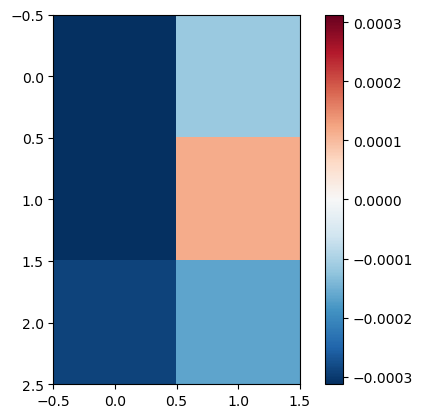

In [8]:
A = jacobiana(1000, 3000, x_rec, y_rec, vp, vs)

escala = np.max(np.abs(A))
plt.imshow(A, vmin=-escala, vmax=escala, cmap="RdBu_r")
plt.colorbar()
plt.show()

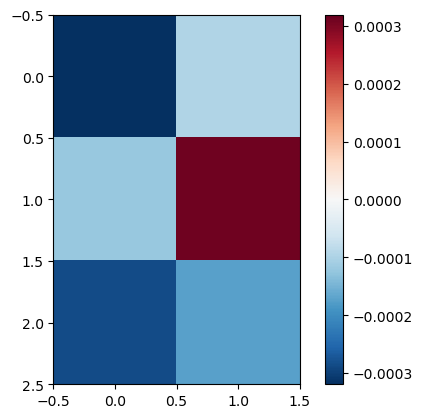

In [9]:
A = jacobiana(5000, 5000, x_rec, y_rec, vp, vs)

escala = np.max(np.abs(A))
plt.imshow(A, vmin=-escala, vmax=escala, cmap="RdBu_r")
plt.colorbar()
plt.show()

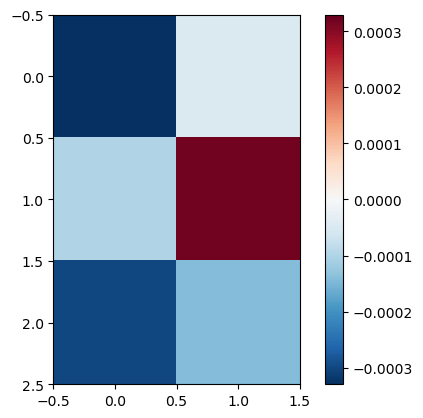

In [10]:
A = jacobiana(x_true, y_true, x_rec, y_rec, vp, vs)

escala = np.max(np.abs(A))
plt.imshow(A, vmin=-escala, vmax=escala, cmap="RdBu_r")
plt.colorbar()
plt.show()

## Inversão por Gauss-Newton

In [24]:
p_inicial = np.array([12000, 8000])

In [25]:
tol = 0.001
max_iterações = 100
p = p_inicial
residuo = dados - dif_tempo(*p, x_rec, y_rec, vp, vs)
func_objetivo = [np.linalg.norm(residuo)**2]
soluções = [p]
for iteração in range(max_iterações):
    A = jacobiana(*p, x_rec, y_rec, vp, vs)
    deltap = np.linalg.solve(A.T @ A, A.T @ residuo)
    p = p + deltap    
    soluções.append(p)
    residuo = dados - dif_tempo(*p, x_rec, y_rec, vp, vs)
    func_objetivo.append(np.linalg.norm(residuo)**2)
    if abs(func_objetivo[-1] - func_objetivo[-2]) / func_objetivo[-2] < tol:
        break

Text(0, 0.5, 'Função objetivo (s²)')

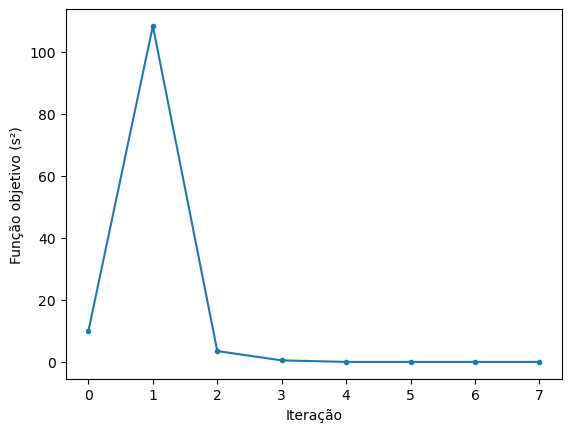

In [26]:
plt.plot(func_objetivo, ".-")
plt.xlabel("Iteração")
plt.ylabel("Função objetivo (s²)")

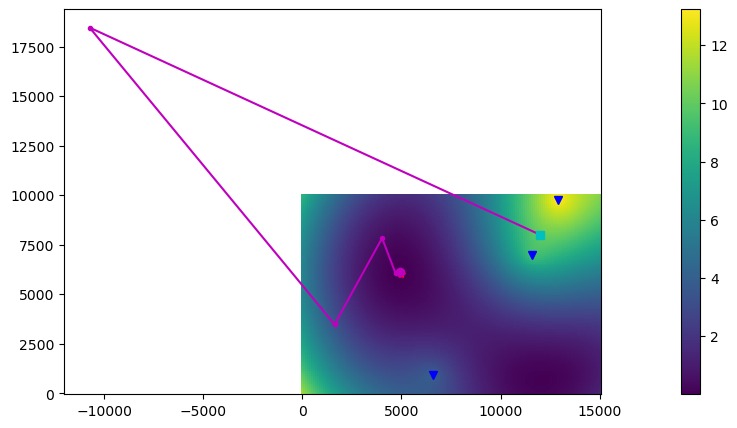

In [27]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(x, y, objetivo)
plt.colorbar()
plt.plot(x_true, y_true, "*r")
plt.plot(x_rec, y_rec, "vb")
plt.plot(*np.transpose(soluções), ".-m")
plt.plot(*p, "om")
plt.plot(*soluções[0], "sc")
plt.xlim(*regiao[:2])
plt.ylim(*regiao[2:])
plt.axis("scaled")
plt.show()

## Steepest descent

In [15]:
tol = 0.01
max_iterações = 100
p = p_inicial
residuo = dados - dif_tempo(*p, x_rec, y_rec, vp, vs)
func_objetivo = [np.linalg.norm(residuo)**2]
soluções_sd = [p]
lamb = 1e6
for iteração in range(max_iterações):
    A = jacobiana(*p, x_rec, y_rec, vp, vs)
    deltap = lamb * A.T @ residuo
    p = p + deltap    
    soluções_sd.append(p)
    residuo = dados - dif_tempo(*p, x_rec, y_rec, vp, vs)
    func_objetivo.append(np.linalg.norm(residuo)**2)
    if abs(func_objetivo[-1] - func_objetivo[-2]) / func_objetivo[-2] < tol:
        break

Text(0, 0.5, 'Função objetivo (s²)')

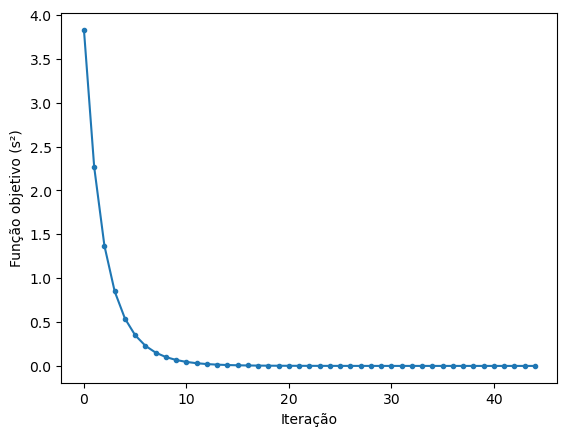

In [16]:
plt.plot(func_objetivo, ".-")
plt.xlabel("Iteração")
plt.ylabel("Função objetivo (s²)")

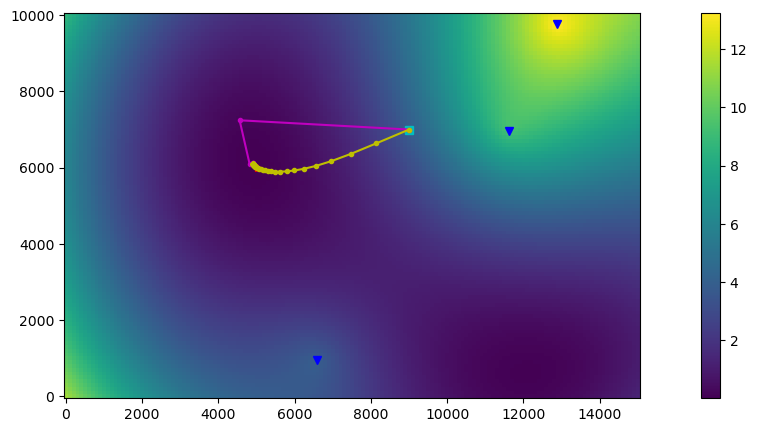

In [17]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(x, y, objetivo)
plt.colorbar()
plt.plot(x_true, y_true, "*r")
plt.plot(x_rec, y_rec, "vb")
plt.plot(*soluções[0], "sc")
plt.plot(*np.transpose(soluções), ".-m")
plt.plot(*np.transpose(soluções_sd), ".-y")
#plt.plot(*p, "om")
plt.xlim(*regiao[:2])
plt.ylim(*regiao[2:])
plt.axis("scaled")
plt.show()

### Line search

In [18]:
tol = 0.01
max_iterações = 100
p = p_inicial
residuo = dados - dif_tempo(*p, x_rec, y_rec, vp, vs)
func_objetivo = [np.linalg.norm(residuo)**2]
soluções_sd = [p]
beta = 0.1
for iteração in range(max_iterações):
    A = jacobiana(*p, x_rec, y_rec, vp, vs)
    gradiente = A.T @ residuo
    norma_gradiente = np.linalg.norm(gradiente)
    direção = gradiente / norma_gradiente * np.linalg.norm(p)
    for m in range(50):
        lamb = beta ** m
        deltap = lamb * direção
        residuo = dados - dif_tempo(*(p + deltap), x_rec, y_rec, vp, vs)        
        if np.linalg.norm(residuo)**2 - func_objetivo[-1] < 1e-4 * lamb:
            break    
    p = p + deltap
    soluções_sd.append(p)
    residuo = dados - dif_tempo(*p, x_rec, y_rec, vp, vs)
    func_objetivo.append(np.linalg.norm(residuo)**2)
    if abs(func_objetivo[-1] - func_objetivo[-2]) / func_objetivo[-2] < tol:
        break

Text(0, 0.5, 'Função objetivo (s²)')

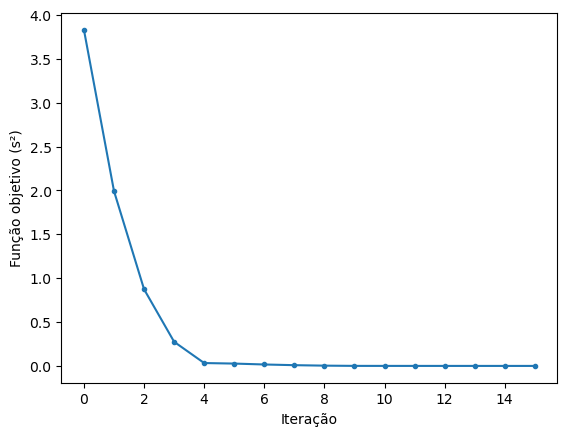

In [19]:
plt.plot(func_objetivo, ".-")
plt.xlabel("Iteração")
plt.ylabel("Função objetivo (s²)")

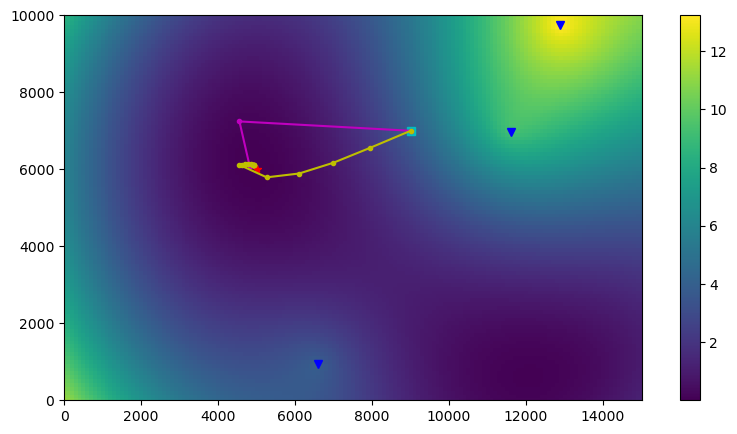

In [20]:
plt.figure(figsize=(10, 5))
plt.axis("scaled")
plt.pcolormesh(x, y, objetivo)
plt.colorbar()
plt.plot(x_true, y_true, "*r")
plt.plot(x_rec, y_rec, "vb")
plt.plot(*soluções[0], "sc")
plt.plot(*np.transpose(soluções), ".-m")
plt.plot(*np.transpose(soluções_sd), ".-y")
#plt.plot(*p, "om")
plt.xlim(*regiao[:2])
plt.ylim(*regiao[2:])
# plt.xlim(4800, 5000)
# plt.ylim(6000, 6200)
plt.show()

## Levemberg-Marquardt

In [21]:
tol = 0.01
max_iterações = 100
p = p_inicial
residuo = dados - dif_tempo(*p, x_rec, y_rec, vp, vs)
func_objetivo = [np.linalg.norm(residuo)**2]
soluções_lm = [p]
alpha = 1
dalpha = 10
I = np.identity(p.size)
for iteração in range(max_iterações):
    A = jacobiana(*p, x_rec, y_rec, vp, vs)
    H = A.T @ A
    # Pre-condicionador de Jacobi
    diagonal = np.abs(np.diagonal(H))
    P = np.diag(1 / diagonal)
    H = P @ H    
    gradiente = P @ A.T @ residuo
    for m in range(50):
        deltap = np.linalg.solve(H + alpha * I, gradiente)
        residuo = dados - dif_tempo(*(p + deltap), x_rec, y_rec, vp, vs)        
        if np.linalg.norm(residuo)**2 > func_objetivo[-1]:
            alpha = alpha * dalpha
        else:
            alpha = alpha / dalpha
            break
    p = p + deltap
    soluções_lm.append(p)
    residuo = dados - dif_tempo(*p, x_rec, y_rec, vp, vs)
    func_objetivo.append(np.linalg.norm(residuo)**2)
    if abs(func_objetivo[-1] - func_objetivo[-2]) / func_objetivo[-2] < tol:
        break

Text(0, 0.5, 'Função objetivo (s²)')

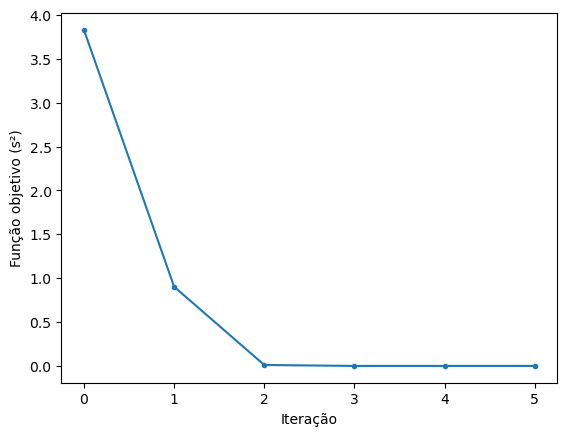

In [22]:
plt.plot(func_objetivo, ".-")
plt.xlabel("Iteração")
plt.ylabel("Função objetivo (s²)")

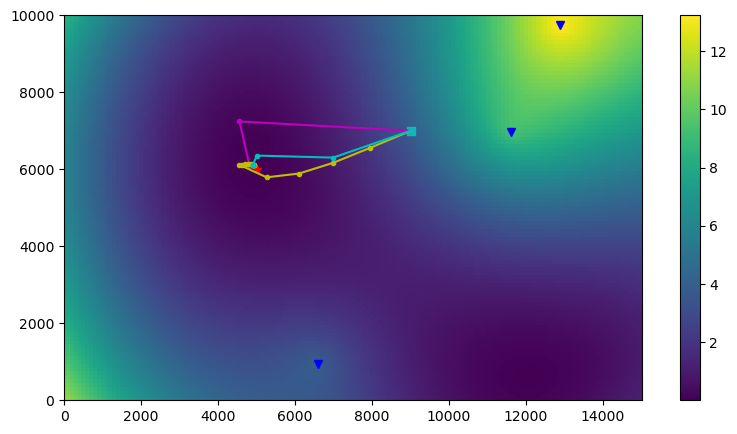

In [23]:
plt.figure(figsize=(10, 5))
plt.axis("scaled")
plt.pcolormesh(x, y, objetivo)
plt.colorbar()
plt.plot(x_true, y_true, "*r")
plt.plot(x_rec, y_rec, "vb")
plt.plot(*soluções[0], "sc")
plt.plot(*np.transpose(soluções), ".-m")
plt.plot(*np.transpose(soluções_sd), ".-y")
plt.plot(*np.transpose(soluções_lm), ".-c")
#plt.plot(*p, "om")
plt.xlim(*regiao[:2])
plt.ylim(*regiao[2:])
# plt.xlim(4850, 4950)
# plt.ylim(6050, 6150)
plt.show()